## Project McNulty

In [24]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit, \
                                        StratifiedKFold, permutation_test_score
from sklearn.feature_selection import RFECV, SelectPercentile, f_classif
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, accuracy_score, precision_score, \
                            recall_score, f1_score, auc, roc_curve, roc_auc_score, classification_report
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import StandardScaler, scale
import seaborn as sns
% matplotlib inline

### Model Search

In [ ]:
def model_search(estimator, tuned_params, scores, X_train, y_train, X_test, y_test):  
    
    cv = ShuffleSplit(len(X_train), n_iter=3, test_size=0.30, random_state=0)

    for score in scores:
        print"# Tuning hyper-parameters for %s" % score
        print

        clf = GridSearchCV(estimator, tuned_params, cv=cv,
                           scoring='%s' % score)
        clf.fit(X_train, y_train)

        print"Best parameters set found on development set:"
        print
        print clf.best_params_
        print
        print "Grid scores on development set:"
        print
        for params, mean_score, scores in clf.grid_scores_:
            print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)
        print

        print "Detailed classification report:"
        print
        print "The model is trained on the full development set."
        print "The scores are computed on the full evaluation set."
        print
        y_true, y_pred = y_test, clf.predict(X_test)
        print classification_report(y_true, y_pred)
        print

### ROC Curve Analysis

In [ ]:
def plot_ROC_curve(y_true, y_score, color, label):
        """
        plots the ROC curve based off of the test data
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        AUC = auc(fpr,tpr)
        
        plt.plot(fpr, tpr, color, label=label + ': ' + str(AUC))
        plt.legend(loc='lower right') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')

#### Setup Dataframe

In [478]:
bank = pd.read_csv('bank-additional.csv', sep=';') 
# Replace yes/no with 1 and 0
bank = bank.replace(['yes','no'], [1,0])
# Puts the outcome variable at the front of the dataframe
cols = bank.columns.tolist()
cols = cols[-1:] + cols[:-1]
bank = bank[cols]
# Drops the unknowns from the data
bank.replace(['unknown'], [np.nan], inplace=True)
bank = bank.dropna()
# Delete features that can't be used for new clients
del bank['duration']
del bank['campaign']
del bank['pdays']
del bank['previous']
del bank['poutcome']

# Add dummies for categorical variables
bank = pd.get_dummies(bank, columns=['month', 'day_of_week', 'job', 'marital', 'education', 'contact'])#, 'poutcome'])

# Delete a column for each categorical variable to use as a base class
del bank['month_mar']
del bank['day_of_week_wed']
del bank['job_blue-collar']
del bank['marital_married']
del bank['education_university.degree']
del bank['contact_cellular']
#del bank['poutcome_nonexistent']

In [479]:
bank.head()

,y,age,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_unemployed,marital_divorced,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,contact_telephone
0,0,30,0,1,0,-1.8,92.893,-46.2,1.313,5099.1,...,0,0,0,0,0,1,0,0,0,0
1,0,39,0,0,0,1.1,93.994,-36.4,4.855,5191.0,...,0,0,1,0,0,0,1,0,0,1
2,0,25,0,1,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,1,0,0,1
4,0,47,0,1,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,0,0,0,0,0,0
5,0,32,0,0,0,-1.1,94.199,-37.5,0.884,4963.6,...,0,0,1,0,0,0,0,0,0,0


#### Randomly shuffle the dataframe

In [480]:
bank = bank.iloc[np.random.permutation(len(bank))]

In [481]:
bank.head()

,y,age,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,job_unemployed,marital_divorced,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,contact_telephone
1503,0,47,0,1,0,1.4,93.918,-42.7,4.962,5228.1,...,0,1,0,0,0,0,1,0,0,0
3515,0,31,0,0,0,1.4,93.918,-42.7,4.957,5228.1,...,0,0,0,0,0,1,0,0,0,0
1710,0,38,0,0,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,1,0,0,1
78,0,33,0,0,0,1.4,94.465,-41.8,4.959,5228.1,...,1,0,0,0,0,1,0,0,0,1
3162,0,27,0,1,0,1.4,93.918,-42.7,4.962,5228.1,...,0,0,1,0,0,0,0,0,1,0


#### Renames columns to get rid of periods and dash's

In [482]:
bank.columns = [u'y', u'age', u'default', u'housing', u'loan',u'emp_var_rate', \
             u'cons_price_idx', u'cons_conf_idx', u'euribor3m', u'nr_employed', \
             u'month_apr', u'month_aug', u'month_dec', u'month_jul', u'month_jun',
             u'month_may', u'month_nov', u'month_oct', u'month_sep', u'day_of_week_fri', u'day_of_week_mon', \
             u'day_of_week_thu', u'day_of_week_tue', u'job_admin', \
             u'job_entrepreneur', u'job_housemaid', u'job_management', u'job_retired', u'job_self_employed', \
             u'job_services', u'job_student', u'job_technician', u'job_unemployed', u'marital_divorced', \
             u'marital_single', u'education_basic_4y', u'education_basic_6y', \
             u'education_basic_9y', u'education_high_school', u'education_illiterate', \
             u'education_professional_course', u'contact_telephone']

#### Create feature interactions

In [57]:
#bank['age_retired'] = bank.age * bank.job_retired
#bank['age_admin'] = bank.age * bank.job_admin
#bank['age_blue'] = bank.age * bank.job_blue_collar
#bank['age_entre'] = bank.age * bank.job_entrepreneur
#bank['age_housemaid'] = bank.age * bank.job_housemaid
#bank['age_manage'] = bank.age * bank.job_management
#bank['age_self'] = bank.age * bank.job_self_employed
#bank['age_serv'] = bank.age * bank.job_services
#bank['age_student'] = bank.age * bank.job_student
#bank['age_tech'] = bank.age * bank.job_technician
#bank['age_unem'] = bank.age * bank.job_unemployed
#bank['age_emp'] = bank.age * bank.emp_var_rate
#bank['age_cons'] = bank.age * bank.cons_price_idx
#bank['age_conf'] = bank.age * bank.cons_conf_idx
#bank['age_eurib'] = bank.age * bank.euribor3m
#bank['age_empl'] = bank.age * bank.nr_employed

In [370]:
#X = bank.values[:,1:].astype(float)
#y = bank.values[:,0].astype(float)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

#X_scaled = scale(X)
    
#std_scale = StandardScaler(copy=True).fit(X_train)
#X_train = std_scale.transform(X_train)
#X_test = std_scale.transform(X_test)

#### Scaled continuous features and create train and test set

In [483]:
X = bank.values[:,1:].astype(float)
y = bank.values[:,0].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

X_add_all = scale(X[:,(0,4,5,6,7,8)])#,9,10,11)])
X_scaled = np.delete(X, (0,4,5,6,7,8), axis=1)#,9,10,11), axis=1)
X_scaled = np.insert(X_scaled, (0,3,3,3,3,3), X_add_all, axis=1)#,3,3,3), X_add_all, axis=1)

std_scale = StandardScaler(copy=True).fit(X_train[:,(0,4,5,6,7,8)])#,9,10,11)])
X_add_train = std_scale.transform(X_train[:,(0,4,5,6,7,8)])#,9,10,11)]) 
X_add_test = std_scale.transform(X_test[:,(0,4,5,6,7,8)])#,9,10,11)])
X_train_scaled = np.delete(X_train, [0,4,5,6,7,8], axis=1)#,9,10,11], axis=1)
X_train_scaled = np.insert(X_train_scaled, (0,3,3,3,3,3), X_add_train, axis=1)#,3,3,3), X_add_train, axis=1)
X_test_scaled = np.delete(X_test, [0,4,5,6,7,8], axis=1)#,9,10,11], axis=1)
X_test_scaled = np.insert(X_test_scaled, (0,3,3,3,3,3), X_add_test, axis=1)#,3,3,3), X_add_test, axis=1)

### Logistic Regression

#### Feature selection

In [12]:
#cv = ShuffleSplit(len(X_train), n_iter=7, test_size=0.30, random_state=0)
#estimator = LogisticRegression()
#selector = RFECV(estimator, step=1, cv=5)
#selector = selector.fit(X_train, y_train) 

In [462]:
#X_train_new = selector.transform(X_train)
#X_test_new = selector.transform(X_test)

####Model tuning

In [486]:
tuned_params = [{'C': [.00001, .0001, .001, .01, .10, 1, 10, 100, 1000]}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']

model_search(LogisticRegression(), tuned_params, scores, X_train_scaled, y_train, X_test_scaled, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 0.0001}

Grid scores on development set:

0.880 (+/-0.013) for {'C': 1e-05}
0.880 (+/-0.012) for {'C': 0.0001}
0.878 (+/-0.016) for {'C': 0.001}
0.878 (+/-0.019) for {'C': 0.01}
0.879 (+/-0.010) for {'C': 0.1}
0.871 (+/-0.012) for {'C': 1}
0.870 (+/-0.018) for {'C': 10}
0.870 (+/-0.018) for {'C': 100}
0.871 (+/-0.018) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.87      1.00      0.93       808
        1.0       0.33      0.01      0.02       119

avg / total       0.80      0.87      0.81       927


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.0001}

Grid scores on development set:

0.443 (+/-0.084) for {'C': 1e-05}
0.462 (+/-0.109) for {'C': 0.0001}
0.000 (+/-0.0

#### Cross validate

In [495]:
log_model = LogisticRegression().fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)

print 'Training Accuracy: ', accuracy_score(y_test, y_pred)

cv = ShuffleSplit(len(X_scaled), n_iter=7, test_size=0.30, random_state=0)
cv_acc = cross_val_score(log_model, X_scaled, y, scoring='accuracy', cv=cv)
print 'Cross Validation Score: {0:0.2f} ({1:0.2f})'.format(cv_acc.mean(), cv_acc.std())

Training Accuracy:  0.873786407767
Cross Validation Score: 0.87 (0.01)


#### Think about writing columns and coefficients to csv to import into javascript

In [425]:
zip(bank.columns[1:], log_model.coef_[0])

[(u'age', 0.00010561515631623113),
 (u'default', -0.0018244460989285767),
 (u'housing', -0.041008084259231692),
 (u'loan', 0.059407521204563322),
 (u'emp_var_rate', -0.35599149600886337),
 (u'cons_price_idx', 0.45704662911204724),
 (u'cons_conf_idx', 0.013503667487591783),
 (u'euribor3m', 0.073213791894367539),
 (u'nr_employed', -0.0085623324260253406),
 (u'month_apr', -0.20141961606777251),
 (u'month_aug', 0.064813062215630865),
 (u'month_dec', 0.10769586077564967),
 (u'month_jul', 0.15149695146889047),
 (u'month_jun', 0.1772762150911277),
 (u'month_may', -0.69310360131128412),
 (u'month_nov', -0.36951603944299366),
 (u'month_oct', -0.018207144225059611),
 (u'month_sep', -0.21511793787486069),
 (u'day_of_week_fri', -0.15730616324683958),
 (u'day_of_week_mon', -0.33833219438302897),
 (u'day_of_week_thu', -0.093926716476159106),
 (u'day_of_week_tue', -0.081208204301114958),
 (u'job_admin', 0.021134525573753452),
 (u'job_entrepreneur', -0.076669225028968044),
 (u'job_housemaid', -0.01458

In [428]:
log_model.intercept_

array([ 0.00244022])

In [436]:
print std_scale.mean_
print std_scale.std_

[  3.89884260e+01  -7.11869172e-02   9.35211947e+01  -4.05883464e+01
   3.46187006e+00   5.16085539e+03]
[ 10.27404393   1.60942547   0.58472209   4.79083757   1.77626918
  75.15150606]


#### Plot ROC Curve

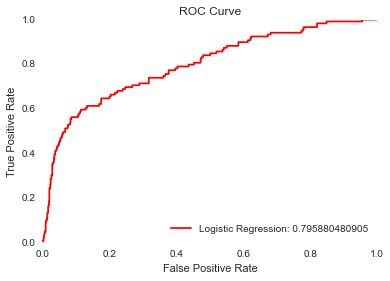

In [496]:
y_scores = log_model.predict_proba(X_test_scaled)
plot_ROC_curve(y_test, y_scores[:,1], 'r', 'Logistic Regression')

### Random Forest

In [494]:
tuned_params = [{'n_estimators': [10,30,100,200,250],  'max_features': [2,4,8]}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']

model_search(RandomForestClassifier(n_jobs=1), tuned_params, scores, X_train_scaled, y_train, X_test_scaled, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_features': 8, 'n_estimators': 200}

Grid scores on development set:

0.872 (+/-0.011) for {'max_features': 2, 'n_estimators': 10}
0.874 (+/-0.020) for {'max_features': 2, 'n_estimators': 30}
0.874 (+/-0.016) for {'max_features': 2, 'n_estimators': 100}
0.873 (+/-0.017) for {'max_features': 2, 'n_estimators': 200}
0.875 (+/-0.018) for {'max_features': 2, 'n_estimators': 250}
0.869 (+/-0.011) for {'max_features': 4, 'n_estimators': 10}
0.876 (+/-0.010) for {'max_features': 4, 'n_estimators': 30}
0.877 (+/-0.012) for {'max_features': 4, 'n_estimators': 100}
0.877 (+/-0.018) for {'max_features': 4, 'n_estimators': 200}
0.874 (+/-0.020) for {'max_features': 4, 'n_estimators': 250}
0.867 (+/-0.008) for {'max_features': 8, 'n_estimators': 10}
0.876 (+/-0.019) for {'max_features': 8, 'n_estimators': 30}
0.875 (+/-0.019) for {'max_features': 8, 'n_estimators': 100}
0.878 (+/-0.022) for {'max_features': 

#### Cross validation

In [497]:
rf = RandomForestClassifier(n_estimators=250, max_depth=10, max_features=2).fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print "Random Forest Accuracy: ", accuracy_score(y_test, y_pred)

cv = ShuffleSplit(len(X_scaled), n_iter=7, test_size=0.30, random_state=0)
cv_accuracy = cross_val_score(rf, X_scaled, y, scoring='accuracy', cv=cv)
print 'Cross Validation Accuracy: {0:0.2f} ({1:0.2f})'.format(cv_accuracy.mean(), cv_accuracy.std())

Random Forest Accuracy:  0.880258899676
Cross Validation Accuracy: 0.88 (0.01)


#### Plot ROC Curve

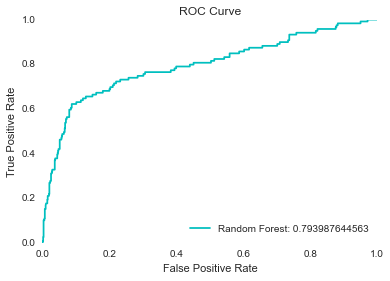

In [498]:
y_scores = rf.predict_proba(X_test_scaled)
plot_ROC_curve(y_test, y_scores[:,1], 'c', 'Random Forest')

### KNearest Neighbors

In [499]:
tuned_params = [{'n_neighbors': range(1,30)}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']

model_search(KNeighborsClassifier(), tuned_params, scores, X_train_scaled, y_train, X_test_scaled, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_neighbors': 12}

Grid scores on development set:

0.824 (+/-0.008) for {'n_neighbors': 1}
0.874 (+/-0.013) for {'n_neighbors': 2}
0.865 (+/-0.010) for {'n_neighbors': 3}
0.877 (+/-0.018) for {'n_neighbors': 4}
0.874 (+/-0.014) for {'n_neighbors': 5}
0.881 (+/-0.022) for {'n_neighbors': 6}
0.875 (+/-0.016) for {'n_neighbors': 7}
0.879 (+/-0.023) for {'n_neighbors': 8}
0.876 (+/-0.026) for {'n_neighbors': 9}
0.881 (+/-0.020) for {'n_neighbors': 10}
0.881 (+/-0.026) for {'n_neighbors': 11}
0.883 (+/-0.020) for {'n_neighbors': 12}
0.882 (+/-0.020) for {'n_neighbors': 13}
0.882 (+/-0.015) for {'n_neighbors': 14}
0.878 (+/-0.014) for {'n_neighbors': 15}
0.879 (+/-0.012) for {'n_neighbors': 16}
0.878 (+/-0.018) for {'n_neighbors': 17}
0.878 (+/-0.016) for {'n_neighbors': 18}
0.878 (+/-0.017) for {'n_neighbors': 19}
0.876 (+/-0.010) for {'n_neighbors': 20}
0.877 (+/-0.012) for {'n_neighbors': 21}
0.878 (

#### Cross Validate

In [500]:
knn = KNeighborsClassifier(n_neighbors=29).fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print "Knn N=29 Accuracy: ", accuracy_score(y_test, y_pred)

cv = ShuffleSplit(len(X_scaled), n_iter=7, test_size=0.30, random_state=0)
cv_accuracy = cross_val_score(knn, X_scaled, y, scoring='accuracy', cv=cv)
print 'Cross Validation Accuracy: {0:0.2f} ({1:0.2f})'.format(cv_accuracy.mean(), cv_accuracy.std())

Knn N=29 Accuracy:  0.870550161812
Cross Validation Accuracy: 0.87 (0.01)


#### Plot ROC Curve

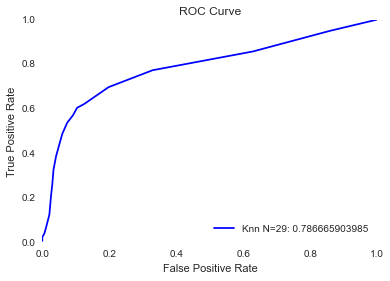

In [501]:
y_scores = knn.predict_proba(X_test_scaled)
plot_ROC_curve(y_test, y_scores[:,1], 'b', 'Knn N=29')

### Support Vector Machine

In [503]:
tuned_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]
scores = ['accuracy', 'precision', 'recall', 'roc_auc']

model_search(SVC(), tuned_params, scores, X_train_scaled, y_train, X_test_scaled, y_test)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'kernel': 'linear', 'C': 10}

Grid scores on development set:

0.882 (+/-0.017) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.882 (+/-0.017) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.882 (+/-0.017) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.882 (+/-0.017) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.882 (+/-0.017) for {'kernel': 'linear', 'C': 1}
0.884 (+/-0.003) for {'kernel': 'linear', 'C': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.88      0.99      0.93       808
        1.0       0.50      0.07      0.12       119

avg / total       0.83      0.87      0.83       927


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'linear', 'C': 10}

Grid scores on devel

#### Cross Validate

In [506]:
svm = SVC(probability=True).fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print "SVM Accuracy: ", accuracy_score(y_test, y_pred)

cv = ShuffleSplit(len(X_scaled), n_iter=7, test_size=0.30, random_state=0)
cv_accuracy = cross_val_score(svm, X_scaled, y, scoring='accuracy', cv=cv)
print 'Cross Validation Accuracy: {0:0.2f} ({1:0.2f})'.format(cv_accuracy.mean(), cv_accuracy.std())

SVM Accuracy:  0.871628910464
Cross Validation Accuracy: 0.88 (0.01)


#### Plot ROC Curve

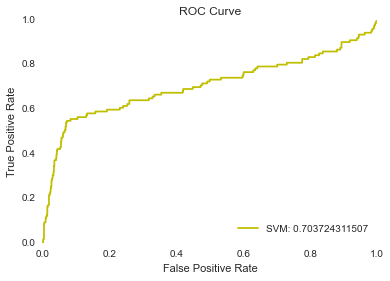

In [507]:
y_scores = svm.predict_proba(X_test_scaled)
plot_ROC_curve(y_test, y_scores[:,1], 'y', 'SVM')

### Naive Bayes

In [508]:
gnb = GaussianNB().fit(X_train_scaled, y_train)
y_pred = gnb.predict(X_test_scaled)
print 'Accuracy Score: {0:0.2f}'.format(accuracy_score(y_test, y_pred))
print 'Precision Score: {0:0.2f}'.format(precision_score(y_test, y_pred))
print 'Recall Score: {0:0.2f}'.format(recall_score(y_test, y_pred))
print 'Roc_Auc Score: {0:0.2f}'.format(roc_auc_score(y_test, y_pred))

Accuracy Score: 0.21
Precision Score: 0.14
Recall Score: 0.97
Roc_Auc Score: 0.54


#### Cross validation

In [509]:
cv = ShuffleSplit(len(X_scaled), n_iter=7, test_size=0.30, random_state=0)
cv_recall = cross_val_score(gnb, X_scaled, y, scoring='recall', cv=cv)
print 'Cross Validation Recall: {0:0.2f} ({1:0.2f})'.format(cv_recall.mean(), cv_recall.std() * 2)

Cross Validation Recall: 0.72 (0.45)


#### Plot ROC Curve

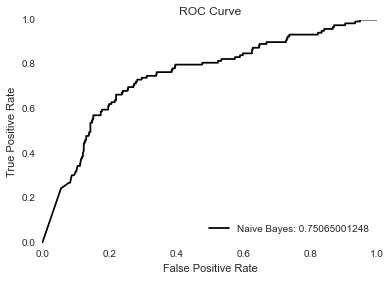

In [511]:
y_scores = gnb.predict_proba(X_test_scaled)
plot_ROC_curve(y_test, y_scores[:,1], 'k', 'Naive Bayes')

#### Testing Recall Score with Permutations

Classification Recall: 0.732432432432 
P-Value: 0.247524752475


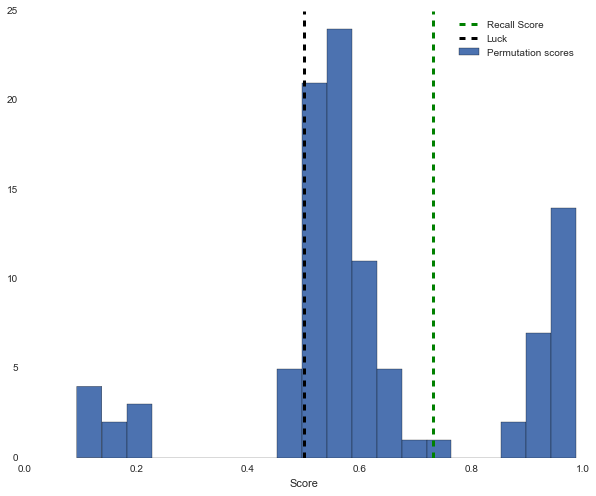

In [510]:
cv = StratifiedKFold(y, 2)

score, permutation_scores, pvalue = permutation_test_score(gnb, X_scaled, y,
                                            scoring='recall', cv=cv,
                                            n_permutations=100, n_jobs=1)

print "Classification Recall: %s \nP-Value: %s" % (score, pvalue)

plt.figure(figsize=(10,8))
n_classes = np.unique(y).size
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
        label='Recall Score')
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()